-9.925952798230824


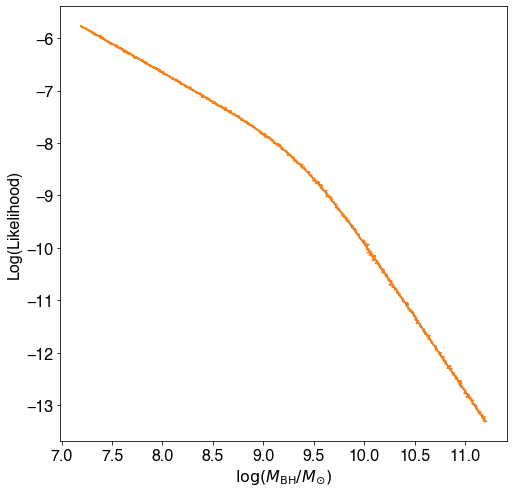

In [8]:
# Create Mass Function Prior File #
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from uncertainties import ufloat
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from uncertainties.umath import *
import scipy.constants as con


warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 16

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def m145_to_300(m145):
    m300 = m145 - 0.38
    return m300

def m300_to_145(m300):
    m145 = m300 + 0.38
    return m145

def calc_fd(mag, zp):
    return 10**(-mag/2.5)*1000*zp

def calc_efd(mag, zp, emag, ezp):
    return np.sqrt((2.0/5.0 * np.log(10) * 10**(-mag/2.5)*zp *emag*1000.0)**2 + (10**(-mag/2.5)*ezp*1000.0)**2)	

def Absmag_to_mag(z, absmag, e_absmag):
    absm = ufloat(absmag, e_absmag)
    dl = cosmo.luminosity_distance(z).to(u.pc)
    mag = absm + 5.*log10(dl.value/10.)
    return mag.n, mag.s

def ABmag_to_flux(ABmag, eABmag):
    zp, ezp = 3631, 36.31
    fd = calc_fd(ABmag, zp)
    efd = calc_efd(ABmag, zp, eABmag, ezp)
    return fd, efd

def fd_to_Lnu(z, wav, fd, efd):
    dl = cosmo.luminosity_distance(z).to(u.cm)
    nu = con.c/wav
    Lnu = fd * 4 * np.pi * dl.value**2 * 10**(-26) * nu
    eLnu = efd * 4 * np.pi * dl.value**2 * 10**(-26) * nu
    return Lnu, eLnu

def L3000_to_Lbol(L3000, eL3000):
    Lnu = ufloat(L3000, eL3000)
    rightside = ufloat(1.852, 1.275) + ufloat(0.975, 0.028)*log10(Lnu)
    Liso = 10**(rightside)
    return 0.75*Liso

def L1450_to_Lbol(L1450, eL1450):
    Lnu = ufloat(L1450, eL1450)
    rightside = ufloat(4.745, 1.007) + ufloat(0.910, 0.022)*log10(Lnu)
    Liso = 10**(rightside)
    return 0.75*Liso


def m145_to_Lbol(z, m145, em145):
    m145, em145 = Absmag_to_mag(z, m145, em145)
    fd145, efd145 = ABmag_to_flux(m145, em145)
    L145, eL145 = fd_to_Lnu(z, 3000E-10, fd145, efd145)
    Lbol = L1450_to_Lbol(L145, eL145)
    return Lbol #ergs/s/Hz

def double_power_law(z, mag, alpha, beta, char_absmag):
    norm = 10**(-8.82-0.47*(z-6))
    result = norm/(10**(0.4*(alpha+1)*(mag-char_absmag))+10**(0.4*(beta+1)*(mag-char_absmag)))
    return result


def Lbol_to_Mbh(edd_rat, Lbol):
    denom = (4*np.pi*con.c*con.G*con.m_p*edd_rat/(con.physical_constants['Thomson cross section'][0]))
    Mbh = Lbol/denom * 10**(-7)
    return Mbh/(2*10**30)

maglist = np.linspace(-21, -32, 1000)
powlawlist = []
for mag in maglist:
    qlf = (double_power_law(4.692, mag, -2.00, -3.60, -27.09))
    powlawlist.append(qlf)
mbhlist = []
for mag in maglist:
    a = m145_to_Lbol(4.692, mag, 0.0)
    mbhlist.append(Lbol_to_Mbh(0.25, a).n)

test_maglist = np.copy(maglist)
test_mbhlist = []
for mag in test_maglist:
    rand_set = 10**np.random.normal(np.log10(0.25), 0.3, 1000)
    a = m145_to_Lbol(4.692, mag, 0.0)
    mbh_temp = Lbol_to_Mbh(rand_set, a)
    mean_mbh = np.nanmedian([i.n for i in mbh_temp])
    test_mbhlist.append(mean_mbh)
    

mbhlist = np.log10(mbhlist)
test_mbhlist = np.log10(test_mbhlist)
lnlike = np.log10(np.array(powlawlist))
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(mbhlist, lnlike)
ax.plot(test_mbhlist, lnlike)

ax.set_xlabel('$\\log(M_{\\rm{BH}}/M_{\\odot})$')
ax.set_ylabel('Log(Likelihood)')


pdata = pd.DataFrame()
pdata['Mbh'] = mbhlist
pdata['logLikelihood'] = lnlike

#pdata.to_csv('test.csv', index=False)